<a href="https://colab.research.google.com/github/LuisFelipeUrena/DS-Unit-2-Kaggle-Challenge/blob/master/Assignments/DS13_TL_BTR_LUIS_URENA_UNIT2_2_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [0]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest,chi2

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [0]:
from sklearn.model_selection import train_test_split

#getting the test and train data
train , val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

In [43]:
test.shape , train.shape , val.shape

((14358, 40), (45042, 41), (14358, 41))

In [0]:
#data wrangling
def wrangle(X):
    X = X.copy()
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()     
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)    
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)    
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    return X

In [0]:
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# The status_group column is the target
target = 'status_group'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [0]:
from sklearn.pipeline import make_pipeline

In [49]:
#Binary encoded with entropy, warmstart and n of estimators gave me faster runtime
#and also improved my validation accuracy.
%%time
pipeline = make_pipeline(
    ce.BinaryEncoder(),
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(random_state=42,n_jobs=-1,max_depth=18,criterion='entropy',
                           warm_start=True,n_estimators=50)

)
pipeline.fit(X_train, y_train)
print('Validation Accuracy: ',pipeline.score(X_val,y_val))

Validation Accuracy:  0.8079816130380276
CPU times: user 11.2 s, sys: 147 ms, total: 11.3 s
Wall time: 7.27 s


In [0]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from random import randint, uniform

In [0]:
param_distributions = {'simpleimputer__strategy':['mean','median','most_frequent','constant'],
                       'randomforestclassifier__n_estimators':[10,100,200,300,400,500],
                       'randomforestclassifier__criterion':['gini','entropy'],
                       'randomforestclassifier__max_depth':range(0,20)}

In [0]:
search = RandomizedSearchCV(
     pipeline, 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

In [53]:
search.fit(X_train,y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.0min
/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:  3.3min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('binaryencoder',
                                              BinaryEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            mapping=None,
                                                            return_df=True,
                                                            verbose=0)),
                                             ('simpleimputer',
                                              SimpleImputer(add_indicator=False,
                                                            copy=True,
                                                            fill_value=None,
        

In [54]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation score', -search.best_score_)

Best hyperparameters {'simpleimputer__strategy': 'most_frequent', 'randomforestclassifier__n_estimators': 400, 'randomforestclassifier__max_depth': 13, 'randomforestclassifier__criterion': 'entropy'}
Cross-validation score -0.7840682030105235


In [55]:

pipeline = search.best_estimator_
#pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)
print('Test Score:',pipeline.score(X_test,y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/_forest.py:359: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Test Score: 1.0


In [56]:
test.columns

Index(['amount_tsh', 'funder', 'gps_height', 'installer', 'longitude',
       'latitude', 'wpt_name', 'num_private', 'basin', 'subvillage', 'region',
       'region_code', 'district_code', 'lga', 'ward', 'population',
       'public_meeting', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group',
       'longitude_MISSING', 'latitude_MISSING', 'construction_year_MISSING',
       'gps_height_MISSING', 'population_MISSING', 'year_recorded',
       'month_recorded', 'day_recorded', 'years', 'years_MISSING'],
      dtype='object')

In [57]:
y_pred

array(['non functional', 'functional', 'functional', ..., 'functional',
       'functional', 'non functional'], dtype=object)

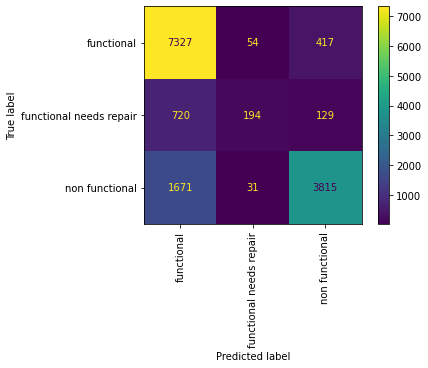

In [58]:
import sklearn
sklearn.__version__

from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(pipeline, X_val, y_val, values_format='.0f', xticks_rotation='vertical')

In [59]:
from sklearn.metrics import classification_report
print (classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.54      0.68      0.60      7798
functional needs repair       0.08      0.02      0.03      1043
         non functional       0.37      0.29      0.33      5517

               accuracy                           0.48     14358
              macro avg       0.33      0.33      0.32     14358
           weighted avg       0.44      0.48      0.46     14358

